In [1]:
# importing libraries
import os 
import time
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import ProbForecastFollmerProcess as pffp

from tqdm.notebook import tqdm
from torch.distributions import MultivariateNormal

In [2]:
# setting plotting style and defining the device
plt.style.use('ggplot')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_folder = "./store/multi_modal_jump_diffusion"
print('Computing on ' + str(device))

Computing on cuda


In [3]:
# setting reproducibility
reproducible = True
SEED = 1024 if reproducible else int(time.time())
pffp.utils.ensure_reproducibility(SEED)

In [4]:
# defining number of dimensions
dim = 2

# defining base gaussian component
mean_0 = torch.tensor([5.0, 0.0], device = device)
cov_0 = torch.tensor([[1.5, 0.0], [0.0, 0.1]], device = device)

# defining number of mixture models
K = 5

# defining rotation angle
theta = torch.tensor([2.0*np.pi/K], device = device)

# defining rotation matrix
R_theta = lambda k: torch.tensor([[torch.cos(k*theta), -torch.sin(k*theta)], [torch.sin(k*theta), torch.cos(k*theta)]], device = device)
rotations = [R_theta(k) for k in range(K)]

# defining mixture
gmm_params = [{"mean": torch.matmul(R, mean_0), "cov": torch.matmul(torch.matmul(R, cov_0), R.T)} for R in rotations]
gmm_components = [MultivariateNormal(params["mean"], params["cov"]) for params in gmm_params]
print(gmm_params)

[{'mean': tensor([5., 0.], device='cuda:0'), 'cov': tensor([[1.5000, 0.0000],
        [0.0000, 0.1000]], device='cuda:0')}, {'mean': tensor([1.5451, 4.7553], device='cuda:0'), 'cov': tensor([[0.2337, 0.4114],
        [0.4114, 1.3663]], device='cuda:0')}, {'mean': tensor([-4.0451,  2.9389], device='cuda:0'), 'cov': tensor([[ 1.0163, -0.6657],
        [-0.6657,  0.5837]], device='cuda:0')}, {'mean': tensor([-4.0451, -2.9389], device='cuda:0'), 'cov': tensor([[1.0163, 0.6657],
        [0.6657, 0.5837]], device='cuda:0')}, {'mean': tensor([ 1.5451, -4.7553], device='cuda:0'), 'cov': tensor([[ 0.2337, -0.4114],
        [-0.4114,  1.3663]], device='cuda:0')}]


In [5]:
# settings of the simulation
delta_t = torch.tensor([1e-2], device = device)
observation_interval = 50

# defining number of observations and iterations
num_iters = int(5e6) 
num_observations = int(num_iters / observation_interval)

# rate of the poisson process
poisson_rate = torch.tensor([2.0], device = device)

# defining the configuration dictionary
simulation_config = {
    "delta_t": delta_t,
    "observation_interval": observation_interval,
    "num_iters": num_iters,
    "num_observations": num_observations,
    "poisson_rate": poisson_rate,
    "gmm_components": gmm_components,
    "R_theta": R_theta,
    "K": K,
    "dim": dim,
    "device": device
}

# checking if the simulation data is stored 
if len(os.listdir(data_folder)) <= 1: # only .gitignore file in the data folder
    print("Data not found, running the simulation")
    # simulating the trajectory we will use for training
    train_state_store, train_observation_store = pffp.utils.simulate_jump_diffusion(simulation_config)
    # simulating the trajectory we will use for testing
    test_state_store, test_observation_store = pffp.utils.simulate_jump_diffusion(simulation_config)
    # saving the simulations so that we won't have to run them again
    torch.save(train_state_store, os.path.join(data_folder, "train_states.pt"))
    torch.save(train_observation_store, os.path.join(data_folder, "train_observations.pt"))
    torch.save(test_state_store, os.path.join(data_folder, "test_states.pt"))
    torch.save(test_observation_store, os.path.join(data_folder, "test_observations.pt"))
else:
    print("Loading simulation data from disk")
    # loading training states and observations
    train_state_store = torch.load(os.path.join(data_folder, "train_states.pt"))
    train_observation_store = torch.load(os.path.join(data_folder, "train_observations.pt"))
    # loading testing states and observations
    test_state_store = torch.load(os.path.join(data_folder, "test_states.pt"))
    test_observation_store = torch.load(os.path.join(data_folder, "test_observations.pt"))
# printing shape of the data
print(f"{train_state_store.shape=}, {train_observation_store.shape=}")
print(f"{test_state_store.shape=}, {test_observation_store.shape=}")

Loading simulation data from disk
train_state_store.shape=torch.Size([5000000, 2]), train_observation_store.shape=torch.Size([100000, 2])
test_state_store.shape=torch.Size([5000000, 2]), test_observation_store.shape=torch.Size([100000, 2])


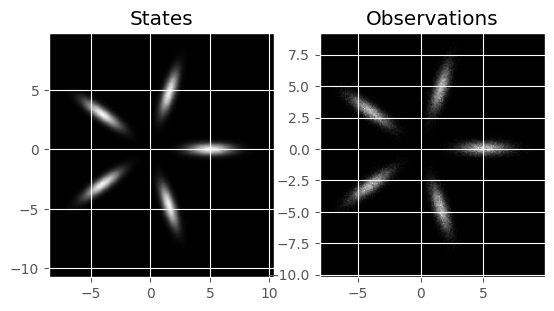

In [6]:
# defining figure and axes
fig, axes = plt.subplots(1, 2)

# plotting the states of the simulated dynamics
x = train_state_store[:,0].detach().cpu()
y = train_state_store[:,1].detach().cpu()
pffp.utils.plot_density(x, y, fig, axes[0], "States")
# plotting the observations of the simulated dynamics
x = train_observation_store[:,0].detach().cpu()
y = train_observation_store[:,1].detach().cpu()
pffp.utils.plot_density(x, y, fig, axes[1], "Observations")

In [7]:
# class for handling the paired lagged datasets
class LaggedDataset(torch.utils.data.Dataset):
    def __init__(self, current_states, next_states, device):
        super(LaggedDataset, self).__init__()
        self.current_states = current_states
        self.next_states = next_states
        self.device = device
    
    def __len__(self):
        return self.next_states.shape[0]
    
    def __getitem__(self, idx):
        current_state = self.current_states[idx].to(self.device)
        next_state = self.next_states[idx].to(self.device)
        return current_state, next_state

In [8]:
# defining lag
lag = 1 # 3 4
# constructing paired lagged observation for training data
X_train, Y_train = pffp.utils.pair_lagged_observations(train_observation_store, lag)
# constructing paired lagged observation for test data
X_test, Y_test = pffp.utils.pair_lagged_observations(test_observation_store, lag)
# constructing dataset from the paired data
train_dataset = LaggedDataset(X_train, Y_train, device = device)
test_dataset = LaggedDataset(X_test, Y_test, device = device)

In [9]:
# defining data configurations
data = {    
    "train": train_dataset, 
    "test": test_dataset, 
}

# defining sampling configurations
sample = {
    "g": pffp.interpolant["sigma"],#pffp.utils.g_follmer, # follmer process not used for this experiment 
    "N": 1000
}

# learning standardization means and standard deviations
standardize = False
standardization = {
    'state_mean': torch.mean(train_observation_store, 0).to(device) if standardize else torch.zeros(dim).to(device),
    'state_std': torch.std(train_observation_store, 0).to(device) if standardize else torch.ones(dim).to(device) ,
}
print(standardization)

# defining network configurations
net_config = {
    "layers": [500]*5, 
    "standardization": standardization
}

# defining state configurations 
state = {
    "dim": dim
}

# defining optimization configurations
optim_config = {
    'batch_size': 1000, 
    'num_epochs': 300,
    'learning_rate' : 0.001,
    'num_mc_samples': 300 
}

# defining model
model = pffp.core.model(data, sample, state, pffp.utils.interpolant, pffp.utils.velocity, net_config, device = "cuda")

if "model.pt" not in os.listdir(data_folder):
    # print model and message
    print(model)
    print("checkpoint not found, starting training")
    # training model
    model.train(optim_config)
    # saving model state dictionary
    torch.save(model.state_dict(), os.path.join(data_folder, "model.pt"))
    # retrieving loss and learning rates
    losses = model.loss
    lrs = model.lrs
    # plotting results
    # defining axes and figure
    fig, axes = plt.subplots(1, 2)
    # plotting loss
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Loss")
    axes[0].plot(losses)
    # plotting learning rates
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Learning rate")
    axes[1].plot(lrs)
else:
    # print model and message
    print("checkpoint found, loading model")
    print(model)
    state_dict = torch.load(os.path.join(data_folder, "model.pt"))
    model.load_state_dict(state_dict)

{'state_mean': tensor([0., 0.], device='cuda:0'), 'state_std': tensor([1., 1.], device='cuda:0')}
checkpoint found, loading model
model(
  (B_net): B_Network(
    (net): MLP(
      (layers): ModuleList(
        (0): Linear(in_features=5, out_features=500, bias=True)
        (1-4): 4 x Linear(in_features=500, out_features=500, bias=True)
        (5): Linear(in_features=500, out_features=2, bias=True)
      )
      (activation_fn): ReLU()
    )
  )
)


In [11]:
# sampling configuration
sample_config = {
    "num_samples": 1
}

# running sampling
(X0, X1), samples = model.sample(sample_config)
print(f"{X0.shape=}, {X1.shape=}, {samples.shape=}")

X0.shape=torch.Size([99999, 2]), X1.shape=torch.Size([99999, 2]), samples.shape=torch.Size([1, 99999, 2])


/tmp/ipykernel_59027/2977508853.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


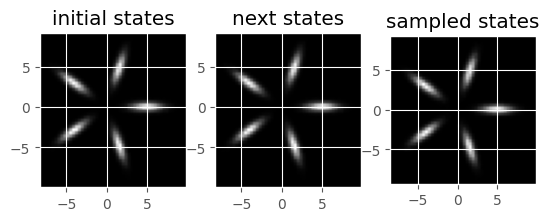

In [12]:
%matplotlib inline
# averaging the samples 
samples_avg = torch.mean(samples, dim = 0)
# retrieving the data
x_hat, y_hat = samples_avg[:, 0].detach().cpu(), samples_avg[:, 1].detach().cpu()
x0, y0 = X0[:, 0].detach().cpu(), X0[:, 1].detach().cpu()
x1, y1 = X1[:, 0].detach().cpu(), X1[:, 1].detach().cpu()

# defining axes and figure
fig, axes = plt.subplots(1, 3)

# plotting the distributions
pffp.utils.plot_density(x0, y0, fig, axes[0], title = "initial states", bins = 50)
pffp.utils.plot_density(x1, y1, fig, axes[1], title = "next states", bins = 50)
pffp.utils.plot_density(x_hat, y_hat, fig, axes[2], title = "sampled states", bins = 50)
fig.show()

/tmp/ipykernel_59027/2633835960.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


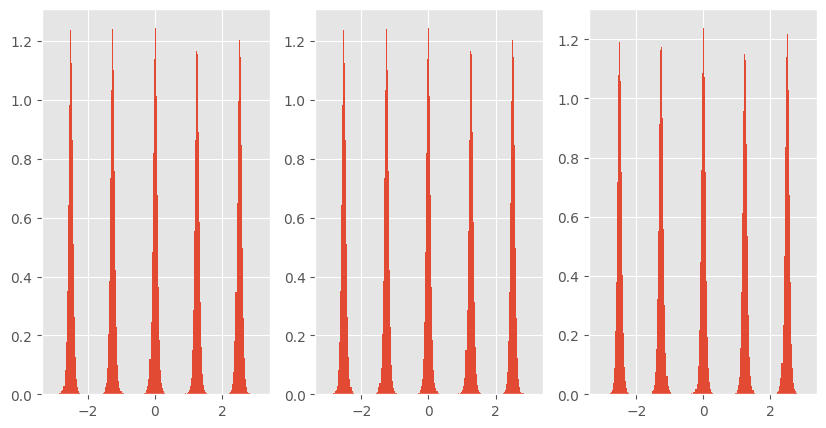

In [13]:
# converting to angular coordinates
theta_0 = pffp.utils.vec2angle(x0,y0)
theta_1 = pffp.utils.vec2angle(x1,y1)
theta_hat = pffp.utils.vec2angle(x_hat,y_hat)

# defining figure and axes
fig, axes = plt.subplots(1, 3, figsize = (10, 5))

# plotting the angular distributions
hist0 = axes[0].hist(theta_0, density = True, bins = 200)
hist1 = axes[1].hist(theta_1, density = True, bins = 200)
hist_hat = axes[2].hist(theta_hat, density = True, bins = 200)

# showing the figure
fig.show()

In [15]:
# autoregressive sampling configuration
sample_config = {
    "num_ar_steps": 1000
}

# running autoregressive sampling
(starting_point, gt_path), ar_samples = model.sample_autoregressive(sample_config)
print(f"{starting_point.shape=}, {gt_path.shape=}, {ar_samples.shape=}")

50 auto regressive steps taken
100 auto regressive steps taken
150 auto regressive steps taken
200 auto regressive steps taken
250 auto regressive steps taken
300 auto regressive steps taken
350 auto regressive steps taken
400 auto regressive steps taken
450 auto regressive steps taken
500 auto regressive steps taken
550 auto regressive steps taken
600 auto regressive steps taken
650 auto regressive steps taken
700 auto regressive steps taken
750 auto regressive steps taken
800 auto regressive steps taken
850 auto regressive steps taken
900 auto regressive steps taken
950 auto regressive steps taken
1000 auto regressive steps taken
starting_point.shape=torch.Size([2]), gt_path.shape=torch.Size([1000, 2]), ar_samples.shape=torch.Size([1000, 2])


/tmp/ipykernel_59027/2849937454.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


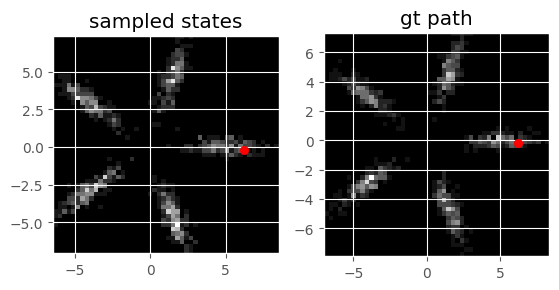

In [16]:
%matplotlib inline
# retrieving the data
x_hat, y_hat = ar_samples[:, 0].detach().cpu(), ar_samples[:, 1].detach().cpu()
x, y = gt_path[:, 0].detach().cpu(), gt_path[:, 1].detach().cpu()

# defining axes and figure
fig, axes = plt.subplots(1, 2)

# plotting the distributions
pffp.utils.plot_density(x_hat, y_hat, fig, axes[0], title = "sampled states", bins = 50)
pffp.utils.plot_density(x, y, fig, axes[1], title = "gt path", bins = 50)
axes[0].scatter(starting_point[0].detach().cpu(), starting_point[1].detach().cpu(), color = "red")
axes[1].scatter(starting_point[0].detach().cpu(), starting_point[1].detach().cpu(), color = "red")
fig.show()

/tmp/ipykernel_59027/1145973119.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


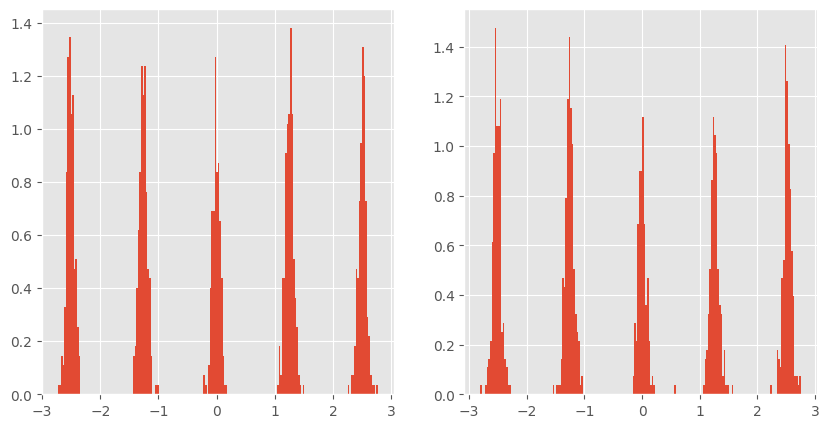

In [17]:
# converting to angular coordinates
theta_gt = pffp.utils.vec2angle(x,y)
theta_hat = pffp.utils.vec2angle(x_hat,y_hat)

# defining figure and axes
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

# plotting the angular distributions
histgt = axes[0].hist(theta_gt, density = True, bins = 200)
hist_hat = axes[1].hist(theta_hat, density = True, bins = 200)

# showing the figure
fig.show()

In [ ]:
# performing sampling over a fixed lag
